# Experimenting with known location

- this playbook contains the code for the experimentation with new location

In [10]:
import os
import csv
import pandas as pd

version = "v6"
dataset_path = f"../data/processed/"

# files
filename_s = f"{version}-2_stages-full_statistical.csv"
filename_s_n = f"{version}-2_stages-full_statistical_normalized.csv"
filename_s_s = f"{version}-2_stages-full_statistical_standardized.csv"
filename_f = f"{version}-2_stages-fourier_int_XYZ.csv"
filename_f_n = f"{version}-2_stages-fourier_normalized_int_XYZ.csv"
filename_f_s = f"{version}-2_stages-fourier_standardized_XYZ.csv"


# datasets
df_statistical = pd.read_csv(f"{dataset_path}/{filename_s}")
df_statistical_normalized = pd.read_csv(f"{dataset_path}/{filename_s_n}")
df_statistical_standardized = pd.read_csv(f"{dataset_path}/{filename_s_s}")
df_spectral = pd.read_csv(f"{dataset_path}/{filename_f}")
df_spectral_normalized = pd.read_csv(f"{dataset_path}/{filename_f_n}")
df_spectral_standardized = pd.read_csv(f"{dataset_path}/{filename_f_s}")

In [121]:
from lib import device_mapping, reverse_device_mapping

# ------------------------------------------------
# choice of dataset

# df = df_statistical # 56, 67
# df = df_statistical_normalized  # 54 63
# df = df_statistical_standardized    # 66, 72
# df = df_spectral    # 74, 77
# df = df_spectral_normalized #77 78
df = df_spectral_standardized   #89, 80

# ------------------------------------------------
# choice of phone

# GooglePixel6:        03575768cc23b2df
# RedmiNote8PRO:       4aaf95a621ccf092
# SamsungGalaxyA51:    029a77f196804217
# SamsungGalaxyS6:     e08d976ac75c011e


# df = df[df['device_id'].isin(reverse_device_mapping(['RedmiNote8PRO']))]
df = df[df['device_id'].isin(reverse_device_mapping(['SamsungGalaxyS6']))]
# df = df[df['device_id'].isin(reverse_device_mapping(['GooglePixel6', 'RedmiNote8PRO']))]
# df = df[df['device_id'].isin(reverse_device_mapping(['SamsungGalaxyA51', 'SamsungGalaxyS6']))]

# ------------------------------------------------
# choice of locations to include TOOD

# number of cases per device
df['device_id'].value_counts()


e08d976ac75c011e    5607
Name: device_id, dtype: int64

In [122]:
correlation = df.iloc[:, 6:].apply(lambda x: df['label'].corr(x, method="pearson")).abs().sort_values(ascending=False)
pd.set_option('display.max_rows', 100)
correlation

Z_2             0.749753
Z_1             0.669508
X_4             0.491263
Z_3             0.473496
intensity_10    0.468222
                  ...   
Z_27            0.014114
X_37            0.012138
Z_15            0.006629
intensity_44    0.004134
Z_24            0.000332
Length: 199, dtype: float64

In [123]:
# feature selection. First k or all greater then some correlation
selection = correlation[:10].index
# selection = correlation[correlation > 0.05].index
df[selection]

,Z_2,Z_1,X_4,Z_3,intensity_10,Y_38,Y_4,Y_33,Y_18,intensity_39
15907,2.886017,6.332829,1.072281,1.685188,0.395975,0.103107,0.856438,0.157726,0.203361,0.136774
15908,2.562289,5.805402,1.067346,2.119760,0.532668,0.140643,1.004826,0.115106,0.183644,0.130922
15909,2.114576,5.232584,1.099255,2.358357,0.359614,0.155081,1.084427,0.150286,0.165979,0.127228
15910,1.568274,4.588048,1.154796,2.287062,0.612291,0.138189,1.069511,0.146115,0.182905,0.126458
15911,1.136524,3.950433,1.161450,1.909607,0.363611,0.098318,1.023360,0.132713,0.227112,0.121670
...,...,...,...,...,...,...,...,...,...,...
37414,0.831759,1.438913,0.815434,0.735693,0.349143,0.242125,0.935733,0.437492,0.656959,0.242783
37415,0.839757,1.433340,0.846439,0.724791,0.359999,0.245543,0.936218,0.435292,0.671709,0.245356
37416,0.887376,1.423364,0.814614,0.722585,0.395484,0.253996,0.865544,0.436309,0.682706,0.252684
37417,0.879475,1.423977,0.807255,0.719474,0.379724,0.249326,0.867924,0.437059,0.695629,0.256107


In [124]:
df['name'].str[:-3].unique()

array(['spelaMilenkosKitchenTrafficTable1_',
       'spelaMilenkosKitchenTrafficTable2_',
       'spelaMilenkosKitchenTrafficTable3_',
       'spelaMilenkosKitchenTrafficTable4_',
       'spelaMilenkosRoomTrafficTable1_',
       'spelaMilenkosRoomTrafficTable2_',
       'spelaMilenkosRoomTrafficTable3_'], dtype=object)

In [125]:
def map_classes(x):
    if x == 5:
        return 1
    return 0
def map_back_classes(x):
    if x == 1:
        return 5
    return 6

In [126]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from lib import device_mapping

results = []
for session in list(df['name'].str[:-3].unique()):

    # test is one location, train the rest
    test = df[df['name'].str.contains(session)]
    train = df[~df['name'].str.contains(session)]

    y_test = test['label'].to_numpy()
    X_test = test[selection].to_numpy()
    y_train = train['label'].to_numpy()
    X_train = train[selection].to_numpy()

    # SVM
    clf = svm.SVC(decision_function_shape='ovo')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_svm = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_test[i]])/len(y_pred)
    f1_svm = f1_score(list(map(map_classes, y_test)), list(map(map_classes, y_pred)))

    # RF
    clf = RandomForestClassifier(max_depth=3)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_rf = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_test[i]])/len(y_pred)
    f1_rf = f1_score(list(map(map_classes, y_test)), list(map(map_classes, y_pred)))

    device_name = device_mapping[test['device_id'].iloc[0]]
    location = test['location'].iloc[0]
    results_temp = [session[:-1], location, device_name, acc_svm, f1_svm, acc_rf, f1_rf]
    results.append(results_temp)
    print(results_temp)

results_all = pd.DataFrame(results, columns=['Session', 'Location', 'Device', 'SVM_acc', 'SVM_f1', 'RF_acc', 'RF_f1'])
results_all

['spelaMilenkosKitchenTrafficTable1', 'Kitchen2', 'SamsungGalaxyS6', 0.9841269841269841, 0.9842805320435308, 0.9841269841269841, 0.9842805320435308]
['spelaMilenkosKitchenTrafficTable2', 'Kitchen2', 'SamsungGalaxyS6', 0.6516290726817042, 0.741635687732342, 0.6679197994987469, 0.7507055503292568]
['spelaMilenkosKitchenTrafficTable3', 'Kitchen2', 'SamsungGalaxyS6', 0.8333333333333334, 0.8292682926829269, 0.8671679197994987, 0.8468208092485549]
['spelaMilenkosKitchenTrafficTable4', 'Kitchen2', 'SamsungGalaxyS6', 0.7669172932330827, 0.696078431372549, 0.7731829573934837, 0.706645056726094]
['spelaMilenkosRoomTrafficTable1', 'DormRoom3', 'SamsungGalaxyS6', 0.9786967418546366, 0.9786700125470514, 0.956140350877193, 0.9572649572649572]
['spelaMilenkosRoomTrafficTable2', 'DormRoom3', 'SamsungGalaxyS6', 1.0, 1.0, 1.0, 1.0]
['spelaMilenkosRoomTrafficTable3', 'DormRoom3', 'SamsungGalaxyS6', 1.0, 1.0, 0.9849624060150376, 0.9851851851851852]


,Session,Location,Device,SVM_acc,SVM_f1,RF_acc,RF_f1
0,spelaMilenkosKitchenTrafficTable1,Kitchen2,SamsungGalaxyS6,0.984127,0.984281,0.984127,0.984281
1,spelaMilenkosKitchenTrafficTable2,Kitchen2,SamsungGalaxyS6,0.651629,0.741636,0.667920,0.750706
2,spelaMilenkosKitchenTrafficTable3,Kitchen2,SamsungGalaxyS6,0.833333,0.829268,0.867168,0.846821
3,spelaMilenkosKitchenTrafficTable4,Kitchen2,SamsungGalaxyS6,0.766917,0.696078,0.773183,0.706645
4,spelaMilenkosRoomTrafficTable1,DormRoom3,SamsungGalaxyS6,0.978697,0.978670,0.956140,0.957265
5,spelaMilenkosRoomTrafficTable2,DormRoom3,SamsungGalaxyS6,1.000000,1.000000,1.000000,1.000000
6,spelaMilenkosRoomTrafficTable3,DormRoom3,SamsungGalaxyS6,1.000000,1.000000,0.984962,0.985185


In [127]:
results_all[['SVM_acc', 'SVM_f1', 'RF_acc', 'RF_f1']].mean()

SVM_acc    0.887815
SVM_f1     0.889990
RF_acc     0.890500
RF_f1      0.890129
dtype: float64

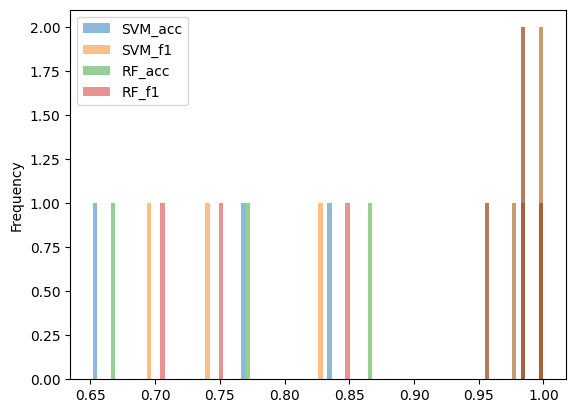

In [128]:
ax = results_all.plot.hist(bins=100, alpha=0.5)